Analyse effectuée le : 2025-04-30 14:37:25 (Heure locale)
------------------------------
Récupération des données pour le ticker : GOOG
Utilisation de la prochaine date d'échéance : 2025-05-02
Dernier prix de clôture connu de GOOG : $158.54
Nombre de contrats Call trouvés : 52
Nombre de contrats Put trouvés : 66
------------------------------
Analyse du Sentiment (Ratio Put/Call) :
Volume Total Calls : 13141.0
Volume Total Puts : 9860.0
Ratio Put/Call (Volume) : 0.75

Open Interest Total Calls : 73610
Open Interest Total Puts : 39376
Ratio Put/Call (Open Interest) : 0.53
------------------------------
Filtrage des options pour l'analyse de la Volatilité Implicite...
(Volume >= 10 ET Open Interest >= 20)
Nombre de Calls retenus pour l'analyse VI : 19
Nombre de Puts retenus pour l'analyse VI : 24
------------------------------
Génération des graphiques...

Affichage des graphiques...


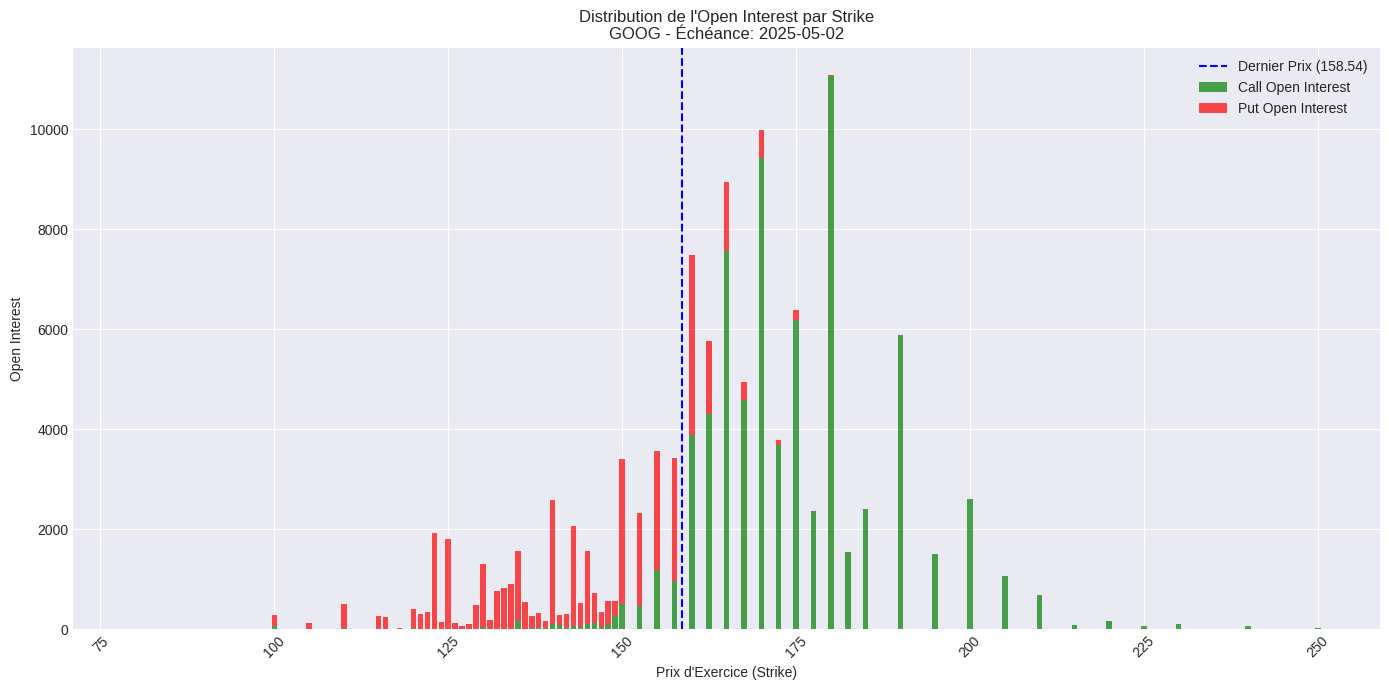

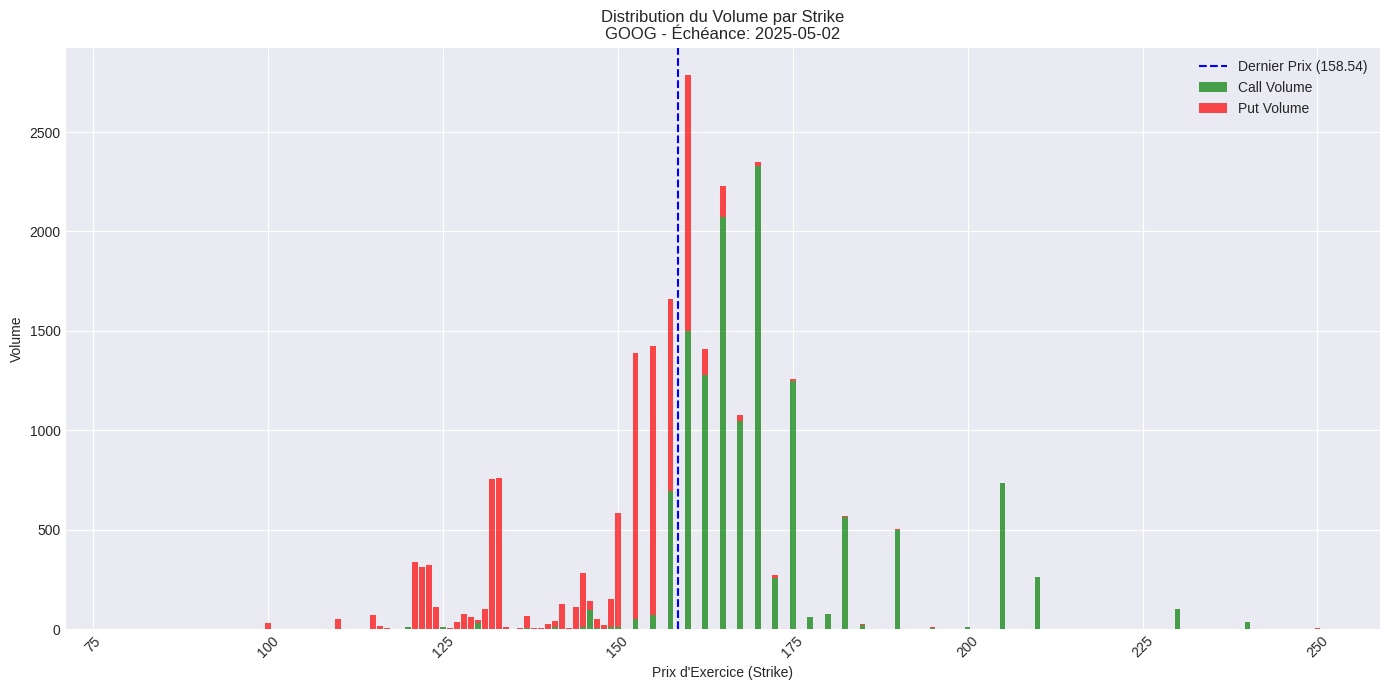

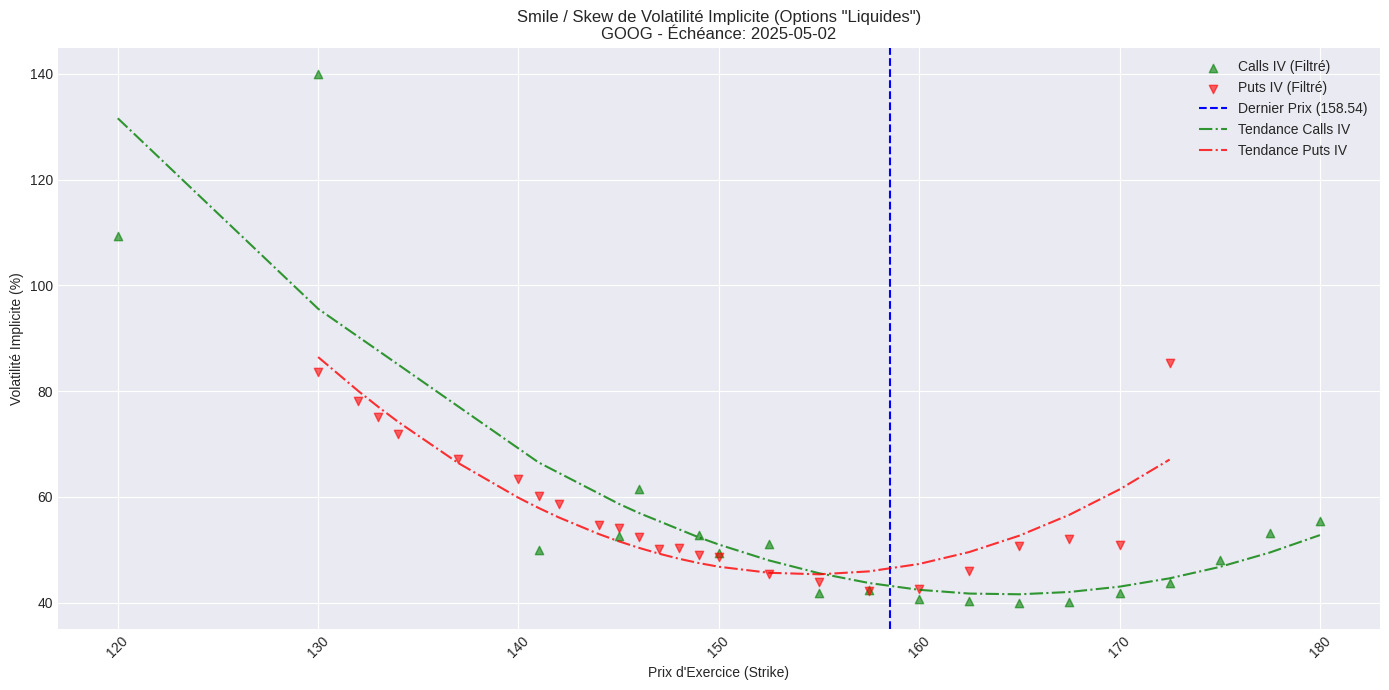


--- Fin de l'analyse ---
RAPPEL : Les données de yfinance sont retardées et la VI des options illiquides n'est pas fiable.


In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

TICKER_SYMBOL = "GOOG"
MIN_VOLUME = 10
MIN_OPEN_INTEREST = 20

now = datetime.now()
print(f"Analyse effectuée le : {now.strftime('%Y-%m-%d %H:%M:%S')} (Heure locale)")
print("-" * 30)


print(f"Récupération des données pour le ticker : {TICKER_SYMBOL}")
ticker = yf.Ticker(TICKER_SYMBOL)

try:
    expiration_dates = ticker.options
    if not expiration_dates:
        print(f"Erreur : Aucune date d'échéance trouvée pour {TICKER_SYMBOL}.")
        exit()

    selected_expiration = expiration_dates[0]
    print(f"Utilisation de la prochaine date d'échéance : {selected_expiration}")

    option_chain = ticker.option_chain(selected_expiration)
    calls = option_chain.calls
    puts = option_chain.puts

    stock_info = ticker.history(period="1d")
    if not stock_info.empty:
        last_stock_price = stock_info['Close'].iloc[-1]
        print(f"Dernier prix de clôture connu de {TICKER_SYMBOL} : ${last_stock_price:.2f}")
    else:
        last_stock_price = None
        print("Impossible de récupérer le dernier prix de l'action.")

except Exception as e:
    print(f"Une erreur est survenue lors de la récupération des données : {e}")
    exit()

if calls.empty and puts.empty:
    print(f"Aucune donnée d'options (calls ou puts) trouvée pour l'échéance {selected_expiration}.")
    exit()

print(f"Nombre de contrats Call trouvés : {len(calls)}")
print(f"Nombre de contrats Put trouvés : {len(puts)}")
print("-" * 30)


print("Analyse du Sentiment (Ratio Put/Call) :")

total_call_volume = calls['volume'].sum() if 'volume' in calls.columns and calls['volume'].notna().any() else 0
total_put_volume = puts['volume'].sum() if 'volume' in puts.columns and puts['volume'].notna().any() else 0
total_call_oi = calls['openInterest'].sum() if 'openInterest' in calls.columns and calls['openInterest'].notna().any() else 0
total_put_oi = puts['openInterest'].sum() if 'openInterest' in puts.columns and puts['openInterest'].notna().any() else 0

pc_volume_ratio = total_put_volume / total_call_volume if total_call_volume > 0 else np.nan
pc_oi_ratio = total_put_oi / total_call_oi if total_call_oi > 0 else np.nan

print(f"Volume Total Calls : {total_call_volume}")
print(f"Volume Total Puts : {total_put_volume}")
print(f"Ratio Put/Call (Volume) : {pc_volume_ratio:.2f}" if not np.isnan(pc_volume_ratio) else "N/A (Volume Call nul)")

print(f"\nOpen Interest Total Calls : {total_call_oi}")
print(f"Open Interest Total Puts : {total_put_oi}")
print(f"Ratio Put/Call (Open Interest) : {pc_oi_ratio:.2f}" if not np.isnan(pc_oi_ratio) else "N/A (OI Call nul)")
print("-" * 30)

call_data_grouped = calls.groupby('strike')[['openInterest', 'volume']].sum()
put_data_grouped = puts.groupby('strike')[['openInterest', 'volume']].sum()

strike_data = pd.merge(
    call_data_grouped.rename(columns={'openInterest': 'call_oi', 'volume': 'call_volume'}),
    put_data_grouped.rename(columns={'openInterest': 'put_oi', 'volume': 'put_volume'}),
    left_index=True,
    right_index=True,
    how='outer'
).fillna(0)

strike_data.index = pd.to_numeric(strike_data.index)
strike_data = strike_data.sort_index()


print("Filtrage des options pour l'analyse de la Volatilité Implicite...")
print(f"(Volume >= {MIN_VOLUME} ET Open Interest >= {MIN_OPEN_INTEREST})")

calls_filtered_iv = calls[
    (calls['volume'] >= MIN_VOLUME) &
    (calls['openInterest'] >= MIN_OPEN_INTEREST) &
    (calls['impliedVolatility'].notna()) &
    (calls['bid'] > 0) &
    (calls['ask'] > 0)
].copy()

puts_filtered_iv = puts[
    (puts['volume'] >= MIN_VOLUME) &
    (puts['openInterest'] >= MIN_OPEN_INTEREST) &
    (puts['impliedVolatility'].notna()) &
    (puts['bid'] > 0) &
    (puts['ask'] > 0)
].copy()

print(f"Nombre de Calls retenus pour l'analyse VI : {len(calls_filtered_iv)}")
print(f"Nombre de Puts retenus pour l'analyse VI : {len(puts_filtered_iv)}")
print("-" * 30)

print("Génération des graphiques...")

plt.style.use('seaborn-v0_8-darkgrid')

# 1: Distribution de l'Open Interest par Strike
fig1, ax1 = plt.subplots(figsize=(14, 7))
bar_width = 0.8
ax1.bar(strike_data.index, strike_data['call_oi'], bar_width, label='Call Open Interest', color='green', alpha=0.7)
ax1.bar(strike_data.index, strike_data['put_oi'], bar_width, label='Put Open Interest', color='red', alpha=0.7, bottom=strike_data['call_oi']) # Empilé
ax1.set_xlabel('Prix d\'Exercice (Strike)')
ax1.set_ylabel('Open Interest')
ax1.set_title(f'Distribution de l\'Open Interest par Strike\n{TICKER_SYMBOL} - Échéance: {selected_expiration}')
if last_stock_price:
    ax1.axvline(last_stock_price, color='blue', linestyle='--', linewidth=1.5, label=f'Dernier Prix ({last_stock_price:.2f})')
ax1.legend()
ax1.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.tight_layout()


# 2: Distribution du Volume par Strike
fig2, ax2 = plt.subplots(figsize=(14, 7))
ax2.bar(strike_data.index, strike_data['call_volume'], bar_width, label='Call Volume', color='green', alpha=0.7)
ax2.bar(strike_data.index, strike_data['put_volume'], bar_width, label='Put Volume', color='red', alpha=0.7, bottom=strike_data['call_volume']) # Empilé
ax2.set_xlabel('Prix d\'Exercice (Strike)')
ax2.set_ylabel('Volume')
ax2.set_title(f'Distribution du Volume par Strike\n{TICKER_SYMBOL} - Échéance: {selected_expiration}')
if last_stock_price:
    ax2.axvline(last_stock_price, color='blue', linestyle='--', linewidth=1.5, label=f'Dernier Prix ({last_stock_price:.2f})')
ax2.legend()
ax2.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.tight_layout()


# Smile / Skew de Volatilité Implicite
fig3, ax3 = plt.subplots(figsize=(14, 7))
if not calls_filtered_iv.empty:
    ax3.scatter(calls_filtered_iv['strike'], calls_filtered_iv['impliedVolatility'] * 100,
                label='Calls IV (Filtré)', color='green', alpha=0.6, marker='^')
if not puts_filtered_iv.empty:
    ax3.scatter(puts_filtered_iv['strike'], puts_filtered_iv['impliedVolatility'] * 100,
                label='Puts IV (Filtré)', color='red', alpha=0.6, marker='v')

ax3.set_xlabel('Prix d\'Exercice (Strike)')
ax3.set_ylabel('Volatilité Implicite (%)')
ax3.set_title(f'Smile / Skew de Volatilité Implicite (Options "Liquides")\n{TICKER_SYMBOL} - Échéance: {selected_expiration}')
if last_stock_price:
    ax3.axvline(last_stock_price, color='blue', linestyle='--', linewidth=1.5, label=f'Dernier Prix ({last_stock_price:.2f})')


if len(calls_filtered_iv) > 3:
    z = np.polyfit(calls_filtered_iv['strike'], calls_filtered_iv['impliedVolatility'] * 100, 2)
    p = np.poly1d(z)
    ax3.plot(np.sort(calls_filtered_iv['strike']), p(np.sort(calls_filtered_iv['strike'])), "g-.", alpha=0.8, label='Tendance Calls IV')

if len(puts_filtered_iv) > 3:
    z = np.polyfit(puts_filtered_iv['strike'], puts_filtered_iv['impliedVolatility'] * 100, 2)
    p = np.poly1d(z)
    ax3.plot(np.sort(puts_filtered_iv['strike']), p(np.sort(puts_filtered_iv['strike'])), "r-.", alpha=0.8, label='Tendance Puts IV')


ax3.legend()
ax3.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.tight_layout()


print("\nAffichage des graphiques...")
plt.show()

print("\n--- Fin de l'analyse ---")
print("RAPPEL : Les données de yfinance sont retardées et la VI des options illiquides n'est pas fiable.")